## The Battle of Neighborhoods: Starting a Taiwanese Bubble Tea Shop

### This is to build models for segmenting neighborhoods in Toronto to explore  suitable locations for starting a Taiwanese Bubble Tea Shop

Applied Data Science Capstone - IBM/Coursera

### Table of Contents

### Introduction
The largest city in Canada, Toronto, containing more than 2.7 million popupation with renowned as one of the most multicultural cities globally because of it attracts immigrants from around the world.

### Business Problem
As the increasing popularity of Taiwanese bubble tea which brings attention worldwide, especially in multicultural cities like L.A, N.Y, S.F; this project is to explore the business in Toronto because of similar characteristics.

Key items in consideration:
- What are most popular locations/venues?
- Are there existing competition, like coffee shop?
- Traffic and pedestrian information, how many people will get around in each location?
- Crime rate and so on.

### Goal
Identifying suitable locations with the considered items listed above, from data science perspective.

### Target Audience
Business owner and stakeholder planning to expand bubble tea business, and this is how data science can be applied.

## Data collection
The following data sources are to be used in the project:
1. Toronto post codes (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M)
2. Popular venues of a given neighborhood in Toronto (https://developer.foursquare.com/)
3. Traffic Signal Vehicle and Pedestrian Volumes, Toronto (https://ckan0.cf.opendata.inter.prod-toronto.ca/en/dataset/traffic-signal-vehicle-and-pedestrian-volumes)
4. Toronto Crime Indicator, Toronto Police Service (https://data.torontopolice.on.ca/datasets/major-crime-indicators-1)

## Data Cleaning, Preparation, and Objectives
<b>1. Toronto post codes:</b> a Wikipedia page about Toronto postal code. We will scrape the page and create a data frame consisting of three columns; PostalCode, Borough, and Neighborhood. We remove any rows that do not have borough assigned. Then, we will be using the Geocoder python package to retrieve the postal code's coordinates. It will return 103 rows and 5 columns.
Objective: To obtain the exact coordinates for each neighborhood based on the postal code, allowing us to explore and map the city.

<b>2. Popular venues:</b> stored inside Foursquare Location Data, and we will use Foursquare API to access it. We utilize the postal coordinates to retrieve popular venues around a specific radius. As a result, the same venue categories will be returned to different neighborhoods. We can use this idea to cluster the neighborhoods based on their venues representing services and amenities.
Objective: leverage Foursquare credentials to access the 2nd data source through its API and retrieve the popular venues along with their details, especially coffee shops

<b>3. Vehicle and Pedestrian Volumes </b>It contains 2280 rows and 11 columns. The rows represent the intersection that each main road has. The data is typically collected between 7:30 a.m. and 6:00 p.m at intersections where there are traffic signals. Each intersection holds vehicle and pedestrian volumes data, along with its coordinates. We will focus on 5 columns; those are Main, 8 Peak Hr Pedestrian Volume, 8 Peak Hr Vehicle Volume, Lattitude, and Longitude. We will use these features to diagnose each main road's characteristics and locate the busiest main roads in the city.
Objective: Analyze pedestrian traffic.

<b>4. Toronto Crime indicator: </b>It contains 242,879 rows and 29 columns. The rows represent crime incidents that reported from 2014 to 2020. It has 5 Major Crime Indicators (MCIs) scattered to 17 divisions and 140 listed neighborhoods. We will group the data based on division and get statistics about crime rates.
Objective: Analyze Crime rate.

## Methodology

### Analytic Approach
To approach the problem with k-means, which is a clustering technique that cluster data points based on sililar characterstics. In this case, it shows audience the neighborhoods clustered in vanue categories.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False

## Toronto post codes
Lastly, we load the 3rd data source and preprocess it to be a neighborhood data frame in previously accomplished work. 
It contains 103 postal codes, 10 boroughs, neighborhood names inside each borough, and their coordinates. Since we are interested in neighborhoods inside Central Toronto, East York, and York boroughs only, we will filter the dataframe. This results in having 3 boroughs and 19 neighborhoods based on postal code coordinates.

#### Step 1. Create data frame containing postal code, bourough/neighborhood.

In [2]:
# retrieve wikipedia webpage
url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(url, 'lxml')

# locate table, create list
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)
# print(table_contents)


# create a data frame with the list
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


#### Step 2. Merge with longitude and latitude, then create a map.

In [3]:
# https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv
# !wget -q -O 'Toronto_long_lat_data.csv'  http://cocl.us/Geospatial_data
df_lon_lat = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv')
df_lon_lat.columns=['PostalCode', 'Latitude', 'Longitude']
df_lon_lat.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [4]:
boroughs_df = pd.merge(df,
                 df_lon_lat[['PostalCode','Latitude', 'Longitude']],
                 on='PostalCode')
boroughs_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


In [5]:
boroughs_df['Neighborhood'] = boroughs_df['Neighborhood'].apply(lambda x:x.split(',')[0])
boroughs_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
3,M6A,North York,Lawrence Manor,43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


In [6]:
# create map of Toronto using latitude and longitude values
!conda install -c conda-forge folium=0.5.0 
import folium # map rendering library
from geopy.geocoders import Nominatim

# get geograpical coordinate of Toronto
address = 'Toronto, ON'
geolocator = Nominatim(user_agent="Toronto")
location = geolocator.geocode(address)
latitude_toronto = location.latitude
longitude_toronto = location.longitude

map_toronto = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=10.5)

# add markers to map
for lat, lng, borough, neighborhood in zip(boroughs_df['Latitude'], boroughs_df['Longitude'], boroughs_df['Borough'], boroughs_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python-3.7-OpenCE

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.2               |     pyhd8ed1ab_0          26 KB  conda-forge
    certifi-2021.5.30          |   py37h89c1867_0         141 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    openssl-1.1.1k             |       h7f98852_0         2.1 MB  conda-forge
    python_abi-3.7             |          2_cp37m           4 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    widgetsnbextension-3.5.1   |   py37h89c1867_4         1.8 MB  conda-f

## Popular venues of a given neighborhood in Toronto 

In [7]:
# Foursquare credential and version
CLIENT_ID = 'W3LC45ZNWRZEGKPE4BVUM2JPEVZVML0OHBI3FVVLAYWZ4V1Y'
CLIENT_SECRET = 'JMNLQ55TXJ5CYUYQEN5H0NOGPXTBSZGZ5MMHJVT344MPJA1R'
VERSION = '20210719'

In [8]:
# define radius and limit of venues
radius = 500
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [66]:
toronto_venues = getNearbyVenues(names=boroughs_df['Neighborhood'],
                                   latitudes=boroughs_df['Latitude'],
                                   longitudes=boroughs_df['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park
Lawrence Manor
Ontario Provincial Government
Islington Avenue
Malvern
Don Mills North
Parkview Hill
Garden District
Glencairn
West Deane Park
Rouge Hill
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate
Guildwood
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor
Thorncliffe Park
Richmond
Dufferin
Scarborough Village
Fairview
Northwood Park
The Danforth  East
Harbourfront East
Little Portugal
Kennedy Park
Bayview Village
Downsview East
The Danforth West
Toronto Dominion Centre
Brockton
Golden Mile
York Mills
Downsview West
India Bazaar
Commerce Court
North Park
Humber Summit
Cliffside
Willowdale
Downsview Central
Studio District
Bedford Park
Del Ray
Humberlea
Birch Cliff
Willowdale South
Downsview Northwest
Lawrence Park
Roselawn
Runnymede
Weston
Dorset Park
York Mills West
Davisville North
Forest Hill North & West
High Park
Westmount
Wexford
W

In [67]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [68]:
# analyze neighborhoods

# one hot encoding
boroughs_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
boroughs_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [boroughs_onehot.columns[-1]] + list(boroughs_onehot.columns[:-1])
boroughs_onehot = boroughs_onehot[fixed_columns]
boroughs_onehot.head()

,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
len(boroughs_onehot.Neighborhood.unique())

99

In [70]:
boroughs_onehot.shape

(2133, 276)

In [71]:
# group rows by neighborhood by mean of occurance frequency
boroughs_grouped = boroughs_onehot.groupby('Neighborhood').mean().reset_index()
boroughs_grouped

,Neighborhood,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,Alderwood,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,Bathurst Manor,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,Bedford Park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,Willowdale West,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
95,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
96,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0
97,York Mills,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
boroughs_grouped.shape

(99, 276)

In [73]:
# put top-N venue in pandas data frame, sort in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [74]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        # Add column names such as 1st, 2nd, 3rd Most Common Venue
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        # Add column names such as 4th, 5th, .. ,10th Most Common Venue
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# In the end, we have:
# columns == ['Neighborhood', '1st Most Common Venue', .. , '10th Most Common Venue']        

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = boroughs_grouped['Neighborhood']

for ind in np.arange(boroughs_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(boroughs_grouped.iloc[ind, :], num_top_venues)

In [75]:
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Latin American Restaurant,Breakfast Spot,Chinese Restaurant,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
1,Alderwood,Pizza Place,Coffee Shop,Gym,Pharmacy,Sandwich Place,Pub,Pool,Distribution Center,Dessert Shop,Dim Sum Restaurant
2,Bathurst Manor,Coffee Shop,Bank,Park,Fried Chicken Joint,Deli / Bodega,Supermarket,Middle Eastern Restaurant,Sushi Restaurant,Ice Cream Shop,Shopping Mall
3,Bayview Village,Café,Bank,Japanese Restaurant,Chinese Restaurant,Diner,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore
4,Bedford Park,Sandwich Place,Coffee Shop,Italian Restaurant,Comfort Food Restaurant,Café,Pub,Sushi Restaurant,Butcher,Liquor Store,Restaurant


### Step 4. Clustering Neighborhoods
k-Means algorithm is to be used in clustering the neighborhoods.
Take coffee shop in finding K value woth elbow method.

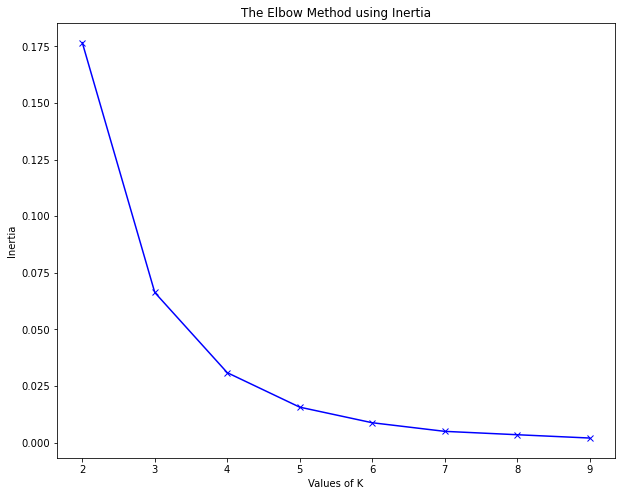

In [76]:
from sklearn.cluster import KMeans

X = boroughs_grouped[['Coffee Shop']]
# find k by elbow method
plt.figure(figsize=[10, 8])
inertia=[]
range_val=range(2,10)
for i in range_val:
    kmean=KMeans(n_clusters=i)
    kmean.fit_predict(X)
    inertia.append(kmean.inertia_)
plt.plot(range_val,inertia,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

In [77]:
# run k-means clustering
boroughs_grouped_clustering = boroughs_grouped.drop('Neighborhood', 1)
# boroughs_grouped_clustering.head()

kclusters = 4
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(boroughs_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2], dtype=int32)

In [78]:
# add clustering labels to df
neighborhoods_venues_sorted['Cluster Labels'] = pd.Series(kmeans.labels_)
neighborhoods_venues_sorted.dtypes

# merge boroughs_grouped with boroughs_df to add latitude/longitude for each neighborhood
temp = neighborhoods_venues_sorted
temp = temp.join(boroughs_merged.set_index('Neighborhood'), on='Neighborhood')
boroughs_merged = temp
boroughs_merged.head()

Neighborhood               object
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
Cluster Labels              int32
PostalCode                 object
Borough                    object
Latitude                  float64
Longitude                 float64
dtype: object

In [79]:
# rearrange columns
columns = [column for column in boroughs_merged.columns if column.endswith('Venue')]
columns = ['Borough', 'Neighborhood', 'Cluster Labels'] + columns

boroughs_merged[columns]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,Agincourt,0,Lounge,Latin American Restaurant,Breakfast Spot,Chinese Restaurant,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
1,Etobicoke,Alderwood,0,Pizza Place,Coffee Shop,Gym,Pharmacy,Sandwich Place,Pub,Pool,Distribution Center,Dessert Shop,Dim Sum Restaurant
2,North York,Bathurst Manor,0,Coffee Shop,Bank,Park,Fried Chicken Joint,Deli / Bodega,Supermarket,Middle Eastern Restaurant,Sushi Restaurant,Ice Cream Shop,Shopping Mall
3,North York,Bayview Village,0,Café,Bank,Japanese Restaurant,Chinese Restaurant,Diner,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore
4,North York,Bedford Park,0,Sandwich Place,Coffee Shop,Italian Restaurant,Comfort Food Restaurant,Café,Pub,Sushi Restaurant,Butcher,Liquor Store,Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,North York,Willowdale West,0,Pharmacy,Grocery Store,Pizza Place,Coffee Shop,Discount Store,Supermarket,Doner Restaurant,Dim Sum Restaurant,Diner,Distribution Center
95,Scarborough,Woburn,0,Coffee Shop,Pharmacy,Korean BBQ Restaurant,Mexican Restaurant,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
96,East York,Woodbine Heights,0,Skating Rink,Park,Intersection,Spa,Video Store,Beer Store,Athletics & Sports,Curling Ice,Doner Restaurant,Discount Store
97,North York,York Mills,0,Cafeteria,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Women's Store,Farmers Market


In [80]:
# retrieve top-3 common venues

temp = boroughs_merged[[column for column in boroughs_merged.columns if (column.startswith('1st')) | (column.startswith('2')) | (column.startswith('3')) | (column=='Cluster Labels')]]
temp

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Cluster Labels
0,Lounge,Latin American Restaurant,Breakfast Spot,0
1,Pizza Place,Coffee Shop,Gym,0
2,Coffee Shop,Bank,Park,0
3,Café,Bank,Japanese Restaurant,0
4,Sandwich Place,Coffee Shop,Italian Restaurant,0
...,...,...,...,...
94,Pharmacy,Grocery Store,Pizza Place,0
95,Coffee Shop,Pharmacy,Korean BBQ Restaurant,0
96,Skating Rink,Park,Intersection,0
97,Cafeteria,Donut Shop,Dim Sum Restaurant,0


#### Step 5. Visualize clusters

In [81]:
# Matplotlib and associated plotting modules
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab

import matplotlib.cm as cm
from matplotlib.cm import rainbow
import matplotlib.colors as colors
import folium # map rendering library
latitude = 43.69479
longitude = -79.41440

Solving environment: done

# All requested packages already installed.



In [82]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(boroughs_merged['Latitude'], boroughs_merged['Longitude'], boroughs_merged['Neighborhood'], boroughs_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
      
map_clusters

### Cluster 1

In [83]:
cluster_0 = boroughs_merged.loc[boroughs_merged['Cluster Labels'] == 0, boroughs_merged.columns[[2] + list(range(5, boroughs_merged.shape[1]))]]
print(cluster_0.shape)
cluster_0

(90, 12)


,2nd Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,PostalCode,Borough,Latitude,Longitude
0,Latin American Restaurant,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,0,M1S,Scarborough,43.794200,-79.262029
1,Coffee Shop,Sandwich Place,Pub,Pool,Distribution Center,Dessert Shop,Dim Sum Restaurant,0,M8W,Etobicoke,43.602414,-79.543484
2,Bank,Deli / Bodega,Supermarket,Middle Eastern Restaurant,Sushi Restaurant,Ice Cream Shop,Shopping Mall,0,M3H,North York,43.754328,-79.442259
3,Bank,Diner,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,0,M2K,North York,43.786947,-79.385975
4,Coffee Shop,Café,Pub,Sushi Restaurant,Butcher,Liquor Store,Restaurant,0,M5M,North York,43.733283,-79.419750
...,...,...,...,...,...,...,...,...,...,...,...,...
93,Coffee Shop,Restaurant,Pizza Place,Café,Discount Store,Ice Cream Shop,Fast Food Restaurant,0,M2N,North York,43.770120,-79.408493
94,Grocery Store,Discount Store,Supermarket,Doner Restaurant,Dim Sum Restaurant,Diner,Distribution Center,0,M2R,North York,43.782736,-79.442259
95,Pharmacy,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,0,M1G,Scarborough,43.770992,-79.216917
96,Park,Video Store,Beer Store,Athletics & Sports,Curling Ice,Doner Restaurant,Discount Store,0,M4C,East York,43.695344,-79.318389


### Cluster 2

In [84]:
cluster_1 = boroughs_merged.loc[boroughs_merged['Cluster Labels'] == 1, boroughs_merged.columns[[2] + list(range(5, boroughs_merged.shape[1]))]]
print(cluster_1.shape)
cluster_1

(1, 12)


,2nd Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,PostalCode,Borough,Latitude,Longitude
73,Women's Store,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,1,M1J,Scarborough,43.744734,-79.239476


### Cluster 3

In [85]:
cluster_2 = boroughs_merged.loc[boroughs_merged['Cluster Labels'] == 2, boroughs_merged.columns[[2] + list(range(5, boroughs_merged.shape[1]))]]
print(cluster_2.shape)
cluster_2

(9, 12)


,2nd Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,PostalCode,Borough,Latitude,Longitude
9,Pool,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,2,M6E,York,43.689026,-79.453512
25,Airport,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,2,M3K,North York,43.737473,-79.464763
55,Intersection,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,2,M1V,Scarborough,43.815252,-79.284577
66,Park,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Dessert Shop,2,M3A,North York,43.753259,-79.329656
69,Trail,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,2,M4W,Downtown Toronto,43.679563,-79.377529
81,Park,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,2,M4J,East York/East Toronto,43.685347,-79.338106
90,Women's Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,2,M9N,York,43.706876,-79.518188
92,Women's Store,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,2,M2M,North York,43.789053,-79.408493
98,Park,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,2,M2P,North York,43.752758,-79.400049


### Cluster 4

In [86]:
cluster_3 = boroughs_merged.loc[boroughs_merged['Cluster Labels'] == 3, boroughs_merged.columns[[2] + list(range(5, boroughs_merged.shape[1]))]]
print(cluster_3.shape)
cluster_3

(1, 12)


,2nd Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,PostalCode,Borough,Latitude,Longitude
54,Drugstore,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,College Rec Center,3,M1B,Scarborough,43.806686,-79.194353


## Vehicle and Pedestrian Volumes 
Average all traffic volumes per each street

In [87]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_b7b5ed42d50c4f528db9840dbbc64394 = 'https://s3.ap.cloud-object-storage.appdomain.cloud'
else:
    endpoint_b7b5ed42d50c4f528db9840dbbc64394 = 'https://s3.private.ap.cloud-object-storage.appdomain.cloud'

client_b7b5ed42d50c4f528db9840dbbc64394 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='KmxGLsfHm8KiXRDg9Pcg01BonVzUUmpQ2A2UAVONSzXp',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_b7b5ed42d50c4f528db9840dbbc64394)

body = client_b7b5ed42d50c4f528db9840dbbc64394.get_object(Bucket='ibmdatasciencecapstoneproject-donotdelete-pr-utmilgmmol1n5g',Key='traffic-signal-vehicle-and-pedestrian-volumes-data.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_ft = pd.read_csv(body)
df_ft.head()


,TCS #,Main,Midblock Route,Side 1 Route,Side 2 Route,Activation Date,Latitude,Longitude,Count Date,8 Peak Hr Vehicle Volume,8 Peak Hr Pedestrian Volume
0,2,JARVIS ST,NaN,FRONT ST E,NaN,11/15/1948,43.649418,-79.371446,06-21-2017,15662,13535
1,3,KING ST E,NaN,JARVIS ST,NaN,08/23/1950,43.650461,-79.371924,09-17-2016,12960,7333
2,4,JARVIS ST,NaN,ADELAIDE ST E,NaN,09/12/1958,43.651534,-79.372360,11-08-2016,17770,7083
3,5,JARVIS ST,NaN,RICHMOND ST E,NaN,04/21/1962,43.652718,-79.372824,12-08-2015,19678,4369
4,6,JARVIS ST,NaN,QUEEN ST E,NaN,08/24/1928,43.653704,-79.373238,09-17-2016,14487,3368


In [88]:
ft_main = df_ft.groupby(by='Main')[['8 Peak Hr Pedestrian Volume','8 Peak Hr Vehicle Volume', 'Latitude', 'Longitude']].mean().sort_values(by='8 Peak Hr Pedestrian Volume', ascending=False).reset_index()
ft_main

,Main,8 Peak Hr Pedestrian Volume,8 Peak Hr Vehicle Volume,Latitude,Longitude
0,BLOOR ST,23335.000000,14398.000000,43.670229,-79.386767
1,BAY ST,17194.750000,14524.450000,43.658325,-79.384589
2,YORK ST,16209.750000,11101.250000,43.647326,-79.383293
3,FRONT ST W,16060.500000,10568.750000,43.643394,-79.390946
4,UNIVERSITY AVE,12846.090909,22119.545455,43.651889,-79.386793
...,...,...,...,...,...
243,TANGIERS RD,23.000000,3016.000000,43.766976,-79.489708
244,ZOO RD,16.000000,1982.000000,43.818187,-79.173580
245,OLD FINCH AVE,0.000000,1081.000000,43.825259,-79.196812
246,SHERWAY GARDENS RD,0.000000,9713.000000,43.613090,-79.552280


In [89]:
ft_main.describe()

,8 Peak Hr Pedestrian Volume,8 Peak Hr Vehicle Volume,Latitude,Longitude
count,248.000000,248.000000,248.000000,248.000000
mean,1855.100736,11274.239194,43.710040,-79.395862
std,3190.819880,5193.129205,0.056145,0.102267
min,0.000000,1081.000000,43.603757,-79.622225
25%,343.500000,7403.750000,43.660016,-79.472370
50%,675.000000,10466.433824,43.703423,-79.390913
75%,1653.678571,13938.031250,43.761615,-79.330196
max,23335.000000,29797.428571,43.825259,-79.140419


In [90]:
ft_main_top = ft_main[(ft_main['8 Peak Hr Pedestrian Volume']>1200) | (ft_main['8 Peak Hr Vehicle Volume']>12000)].reset_index()
ft_main_top.drop(columns='index', inplace=True)
print(ft_main_top.shape)
ft_main_top.head()

(139, 5)


,Main,8 Peak Hr Pedestrian Volume,8 Peak Hr Vehicle Volume,Latitude,Longitude
0,BLOOR ST,23335.000000,14398.000000,43.670229,-79.386767
1,BAY ST,17194.750000,14524.450000,43.658325,-79.384589
2,YORK ST,16209.750000,11101.250000,43.647326,-79.383293
3,FRONT ST W,16060.500000,10568.750000,43.643394,-79.390946
4,UNIVERSITY AVE,12846.090909,22119.545455,43.651889,-79.386793


Filter main road with the criteria: > 1,200 pedirtsians or > 12,000 vehicles in peak hour.
139 main road retrived.

In [91]:
import folium # map rendering library
from geopy.geocoders import Nominatim

address = 'Toronto, Ontario'

# Define a unique user_agent
geolocator = Nominatim(user_agent="toronto_explorer")

# Retrieve Toronto coordinate
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.6534817, -79.3839347.


In [92]:

# create map of Toronto using latitude and longitude values
ft_map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10.5)

# add markers to map
for lat, lng, mainroad, pedes, vehic in zip(ft_main_top['Latitude'], ft_main_top['Longitude'], ft_main_top['Main'], ft_main_top['8 Peak Hr Pedestrian Volume'], ft_main_top['8 Peak Hr Vehicle Volume']):
    label = '{}, (Pedestrian Volume Avg: {}, Vehicle Volume Avg: {})'.format(mainroad, round(pedes, 2), round(vehic, 2))
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='white',
        fill_opacity=0.7,
        parse_html=False).add_to(ft_map_toronto)  
    
ft_map_toronto

## Crime Indicator

In [37]:

body = client_b7b5ed42d50c4f528db9840dbbc64394.get_object(Bucket='ibmdatasciencecapstoneproject-donotdelete-pr-utmilgmmol1n5g',Key='Major_Crime_Indicators.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

mci_df = pd.read_csv(body)
mci_df.head()


/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,premises_type,offence,MCI,Division,Hood_ID,Neighbourhood,Lat,Long,reportedyear
0,House,Assault,Assault,D23,1,West Humber-Clairville (1),43.725321,-79.588477,2014
1,Outside,Assault,Assault,D23,1,West Humber-Clairville (1),43.750187,-79.600166,2014
2,Apartment,B&E,Break and Enter,D23,1,West Humber-Clairville (1),43.719158,-79.603420,2014
3,Outside,Assault With Weapon,Assault,D23,1,West Humber-Clairville (1),43.734013,-79.590332,2014
4,Outside,Assault Bodily Harm,Assault,D23,1,West Humber-Clairville (1),43.734013,-79.590332,2014


In [38]:
print('Unique neighborhood: ', len(mci_df['Hood_ID'].unique()))

Unique neighborhood:  142


Group by Division instead of neighborhood, for an insight to identify safest boroughs.

In [39]:
mci_divison = mci_df.groupby('Division').count().sort_values(by='offence', ascending=False).reset_index()
mci_divison

,Division,premises_type,offence,MCI,Hood_ID,Neighbourhood,Lat,Long,reportedyear
0,D51,20472,20472,20472,20472,20472,20472,20472,20472
1,D32,18176,18176,18176,18176,18176,18176,18176,18176
2,D43,17936,17936,17936,17936,17936,17936,17936,17936
3,D41,17866,17866,17866,17866,17866,17866,17866,17866
4,D31,17773,17773,17773,17773,17773,17773,17773,17773
5,D14,17772,17772,17772,17772,17772,17772,17772,17772
6,D23,15622,15622,15622,15622,15622,15622,15622,15622
7,D52,15242,15242,15242,15242,15242,15242,15242,15242
8,D42,15167,15167,15167,15167,15167,15167,15167,15167
9,D22,14824,14824,14824,14824,14824,14824,14824,14824


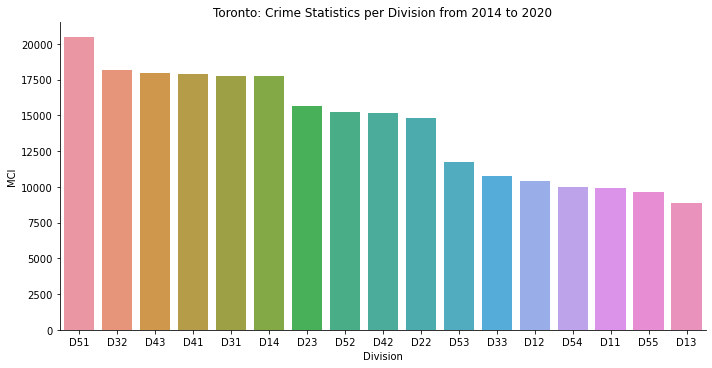

In [40]:
import seaborn as sns
g = sns.catplot(data = mci_divison, x='Division', y='MCI', kind='bar', aspect=2)
g.set(title='Toronto: Crime Statistics per Division from 2014 to 2020')

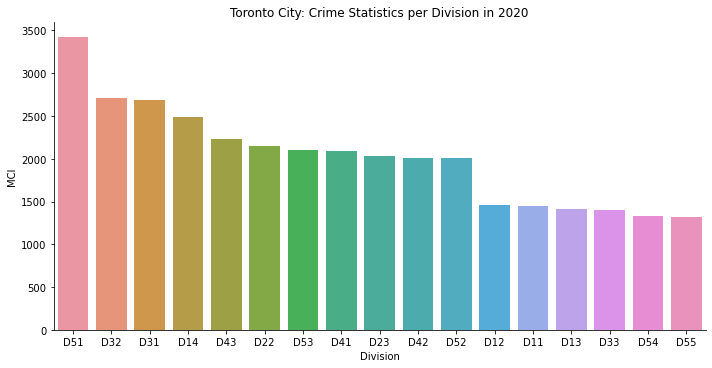

In [41]:
mci_2020 = mci_df[mci_df['reportedyear']==2020]
mci_2020_divison = mci_2020.groupby('Division').count().sort_values(by='offence', ascending=False).reset_index()
g = sns.catplot(data = mci_2020_divison, x='Division', y='MCI', kind='bar', aspect=2)
g.set(title='Toronto City: Crime Statistics per Division in 2020')

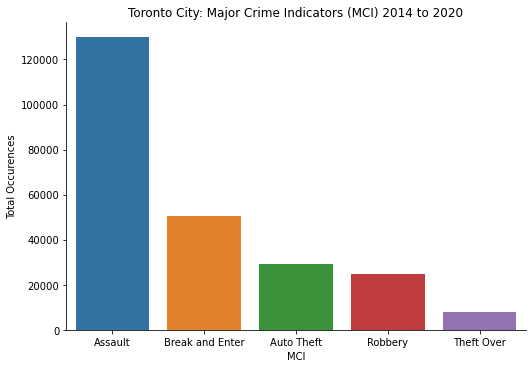

In [42]:
mci_group = mci_df.groupby(by='MCI').count().sort_values(by='offence', ascending=False).reset_index()
g = sns.catplot(data = mci_group, x='MCI', y='offence', kind='bar', aspect=1.5)
g.set(title='Toronto City: Major Crime Indicators (MCI) 2014 to 2020', ylabel='Total Occurences')

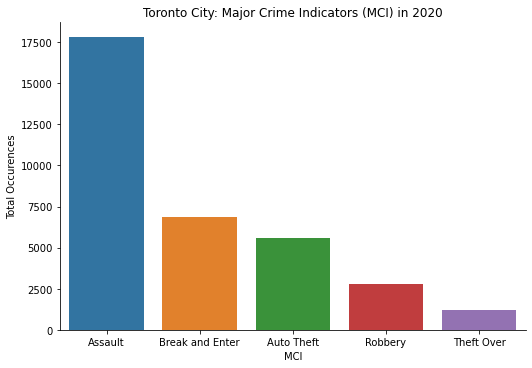

In [43]:
mci_2020_group = mci_2020.groupby(by='MCI').count().sort_values(by='offence', ascending=False).reset_index()
g = sns.catplot(data = mci_2020_group, x='MCI', y='offence', kind='bar', aspect=1.5)
g.set(title='Toronto City: Major Crime Indicators (MCI) in 2020', ylabel='Total Occurences')

Assult is the highest incidents within the 7 years.
The divisions are categorized below based on incident numbers:
- High crime rate: D51, D32, D43, D41, D31, D14
- Middle crime rate: D23, D52, D42, D22
- Low crime rate: D53, D33, D12, D54, D11, D55, D13

Hence the suitable locations are where crime rate are low, referred to Toronto police wiki:
- Central Toronto: D11, D12, D53
- East York: D12, D53, D54, D55
- York: D13

## Results

The goal of this project is to identify suitable locations to open a Taiwanese bubble tea shop in Toronto. It would be subjective to define "suitable", yet we may line up the consideration in the following through analysis results:

<b>Safety</b>
The location with lowest crime rate can be considered.

<b>Accessibility and Demographics</b>
- Accessibility: pedistrian vehicle traffics are the keys to select a location. Central Toronto, East York, and York are identified that meets traffic volume requirement. Knowing how and why to reach the shop location are also crutial, like parking lots, bus stations, visibility, and convenience. This requires further team discussion.
- Demographic: As threshold on traffic set to filter out high traffic and pedistrian, it remains upcoming identification to clarify whether target demographic exists. Hence further investigation of target demographic is required through team discussion.

<b>Neighborhood Business</b>
- Cluster 1: Coffee shops, restaurants (highly competitive)
- Cluster 2: Convenient stores, restaurants (less competitive)
- Cluster 3: Fast food, stores (less competitive)
- Cluster 4: Ball park, stores (tea truck may be considered in playing season)

## Conclusion
Finding a suitable location to start bubble tea business, like other business, is challenging with various uncertainty. Throughout the analysis, it is believed hepful to gain meaningful insights to see more clearly, although further works on discussion and more analysis will be required.
Hope this is helpful in dealing with similar cases.